In [ ]:
# libraries
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#!pip install hmmlearn
#from hmmlearn import hmm
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [ ]:
# load text files, merge together and convert to lowercase

filename = "hp1.txt"
raw_text = open(filename, 'r', encoding= 'unicode_escape').read()
raw_text = raw_text.lower()

In [ ]:
tokenised_text_ = nltk.word_tokenize(raw_text)
len(tokenised_text_)

98823

Mixed order Markov Models

In [ ]:
# log likelihood and perplexity for model evaluation

def logLikelihood(N,M):
  return np.sum(np.multiply(N,np.log(M+(1/M.shape[0]))))

def perplexity(l,n):
  return np.exp(-l/n)

In [ ]:
# get short samples of text
sizes = [100,200,300,500]
n_samples = 5
groups = []
for size in sizes:
  subsamples = []
  for s in range(n_samples):
    start = np.random.choice(np.arange(len(tokenised_text_)))
    subsamples.append(tokenised_text_[start:start+size])
  groups.append(subsamples)

In [ ]:
# global parameters
m = 4
n_iters = 4
groups_metrics = [] # save groups of log-likelihoods, perplexities for each 
groups_M = []
groups_L = []

for l in range(len(groups)):

  print('Enter subsamples of size {}'.format(sizes[l]))
  print('')

  subsamples = groups[l]
  logliks_global, ppxs_global = [], []
  nonzeroM_global, nonzeroL_global = [], []
  M_global = []
  L_global = []

  # iterate over subsamples
  for ix,subsample in enumerate(subsamples):

    print('Enter subsample {}/{}'.format(ix+1,n_samples))

    uniques = list(np.unique(subsample))

    # for each distinct word, save positions where it occurs in the original text
    word_pos = []
    for match in uniques:
      row = []
      for w_ix, w in enumerate(subsample):
        if w == match: row.append(w_ix)
      word_pos.append(row)

    # initialise lambda and M parameters
    lambdas = np.random.rand(len(uniques),m) # random
    lambdas[:,-1] = 1.0
    #lambdas = np.zeros((len(uniques),m))
    #lambdas[:] = [0.9, 0.92, 0.95, 1.0] # last prob is 1.0 because i do not want to look beyond m-th prev word in any case

    # count bigrams of k-th order, k=1,...,m and initialise M with those counts (normalised as probabilities)
    # words on rows are w_t, words on columns are w_t-1 (NOTE: in the paper, M is transposed, but I prefer it like this)
    M = np.zeros((m,len(uniques),len(uniques)))
    for k in range(1,m+1):
      n = []
      for w_ix, w_to in enumerate(uniques): # for each distinct word
        curr_list = word_pos[w_ix] # look at all positions of w_to
        row = [] # make new row
        total_ct = 0.0 # init row total
        for w_from in uniques:
          ct = 0.0 # init in-row word count
          for i in range(len(curr_list)): # check pos of current word and look at previous word
            if curr_list[i] >= k and subsample[curr_list[i]-k] == w_from: ct+=1.0
              # don't look at the last k index in the global list; if previous word is same as curr word, add 1
          row.append(ct) # append current count to row count
          total_ct += ct
        if total_ct > 0:
          n.append(list(np.array(row)/total_ct)) # append row count to current row
        else: n.append(list(np.zeros(len(uniques))))
      M[k-1] = n

    # count bigrams of k-th order, k=1,...,m and store them in N
    N = np.zeros((m,len(uniques),len(uniques)))
    for k in range(1,m+1):
      n = []
      for w_ix, w_to in enumerate(uniques): # for each distinct word
        curr_list = word_pos[w_ix] # all positions of w_to
        row = [] # make new row
        total_ct = 0.0 # init row total
        for w_from in uniques: # check all the words
          ct = 0.0 # init in-row word count
          for i in range(len(curr_list)): # find loc of current word and look at previous word
            if curr_list[i] >= k and subsample[curr_list[i]-k] == w_from: ct+=1.0
              # don't look at the first k indices in the global list; if previous word is same as curr word, add 1
          row.append(ct) # append current count to row count
        n.append(list(np.array(row))) # append row count to current row
      N[k-1] = n

    #print('N:',m*len(uniques)*len(uniques), np.count_nonzero(N!=0), np.round((np.count_nonzero(N!=0))/(m*len(uniques)*len(uniques)),4))
    #print('M:',m*len(uniques)*len(uniques), np.count_nonzero(M!=0), np.round((np.count_nonzero(M!=0))/(m*len(uniques)*len(uniques)),4))
    #print('lambdas:',m*len(uniques), np.count_nonzero(lambdas!=0), (np.count_nonzero(lambdas!=0))/(m*len(uniques)))

    # EM algorithm
    logliks = [] # log-likelihoods
    ppxs = [] # perplexities
    nonzerosM = [] # % of non-zero values in M
    nonzerosL = [] # % of non-zero values in lambdas
    Ms = np.zeros((n_iters,m,len(uniques),len(uniques)))
    Ls = np.zeros((n_iters,len(uniques),m))

    for iter in tqdm(range(n_iters)):
      
      # E step

      # estimate phis
      phi = np.zeros((m,len(subsample)))
      for t in range(0,len(subsample)): # select position t (start from k, otherwise I can't look k words back)
        i_t = subsample[t] # word at position t
        w_t = uniques.index(i_t) # index of word at position t
        # denominator, same for all k's at position t
        den = 0.0
        for k_ in range(1,m+1): # loop over all k
          if k_ < t:
            # i already have word at position t, which is fixed in this loop
            i_tk_ = subsample[t-k_] # word at position t-k_
            w_tk_ = uniques.index(i_tk_) # index of word at position t-k_
            d = lambdas[w_tk_,k_-1]*M[k_-1,w_t,w_tk_] # same as before
            prod_ = 1.0
            if k_>1:
              for j_ in range(1,k_):
                i_tj_ = subsample[t-j_]
                w_tj_ = uniques.index(i_tj_)
                prod_ = prod_*(1-lambdas[w_tj_,j_-1])
            d = d*prod_
            den = den + d
        # numerator
        for k in range(1,m+1): # select current k
          if k < t:        
            i_tk = subsample[t-k] # word at position t-k
            w_tk = uniques.index(i_tk) # index of word at position t-k
            num = lambdas[w_tk,k-1]*M[k-1,w_t,w_tk] # initialise numerator
            prod = 1.0 # prepare to multiply by product of (1-lambdas)
            if k>1:
              for j in range(1,k):
                i_tj = subsample[t-j] # word at position t-j
                w_tj = uniques.index(i_tj) # index of word at position t-j
                prod = prod*(1-lambdas[w_tj,j-1]) # probs of not stopping earlier
              num = num*prod

            if num > 0:
              #phi_k.append(num/den)
              phi[k-1,t] = num/den
            else: phi[k-1,t] = 0.0
        #phi.append(phi_k)
        
      # M step

      # update lambdas
      for k in range(1,m+1): # for all k's
        for i in range(len(uniques)): # for all distinct words
          w = subsample[i] # select this word
          # numerator
          num = 0.0
          for t in range(k,len(subsample)):
            if (w == subsample[t-k]):
              #num += phi[k-1][t-k] # I put t-k bc t starts from k and phis start from k-th word
              num += phi[k-1,t]
          # denominator
          den = 0.0
          for t in range(k,len(subsample)):
            for j in range(k,m+1):
              if (w == subsample[t-k]):
                #den += phi[j-1][t-j]
                den += phi[j-1,t]
          # compute lambda
          if num > 0:
            if k == m:
              lambdas[i,k-1] = 1.0
            else:
              lambdas[i,k-1] = num/den
          else: lambdas[i,k-1] = 0.0

      # update M
      for k in range(1,m+1):
        for i in range(len(uniques)): # w_to, row index of M
          w_to = subsample[i]
          for j in range(len(uniques)): # w_from, col index of M
            w_from = subsample[j]
            # numerator
            num = 0.0
            for t in range(k,len(subsample)):
              if ((w_from == subsample[t-k]) & (w_to == subsample[t])):
                #num += phi[k-1][t-k] # I put t-k bc phi does not include first k words
                num += phi[k-1,t]
            # denominator
            den = 0.0
            for t in range(k,len(subsample)):
              if (w_from == subsample[t-k]):
                #den += phi[k-1][t-k] # I put t-k bc phi does not include first k words
                den += phi[k-1,t]
            # compute lambda
            if num > 0:
              M[k-1,i,j] = num/den
            else: M[k-1,i,j] = 0.0

      # log likelihood and perplexity of each model at this iteration
      log_this = []
      ppx_this = []
      nonzeroM = []
      nonzeroPhi = []
      nonzeroL = []
      for k in range(m):
        log_this.append(logLikelihood(N[k],M[k]))
        ppx_this.append(perplexity(logLikelihood(N[k],M[k]),len(uniques)))
        nonzeroM.append(np.round(np.count_nonzero(M[k]!=0)/(len(uniques)*len(uniques)),5))
        nonzeroPhi.append(np.round(np.count_nonzero(phi[k]!=0)/len(subsample),5))
        nonzeroL.append(np.round(np.count_nonzero(lambdas[:,k]!=0)/len(uniques),5))
      logliks.append(log_this)
      ppxs.append(ppx_this)
      nonzerosM.append(nonzeroM)
      nonzerosL.append(nonzeroL)
      Ms[iter,:] = M # save M for this iteration
      Ls[iter,:] = lambdas # save lambdas for this iteration, (len(uniques),4) size

      # the amount of non-zero elements decreases with subsequent iterations 
      #print('')
      #print('Iter {}'.format(iter+1))
      #print('M:',nonzeroM)
      #print('lambdas:',nonzeroL)
      #print('Log-likelihoods:', log_this)
      #print('Perplexities:', ppx_this)
      #print('')

    logliks_global.append(logliks)
    ppxs_global.append(ppxs)
    nonzeroM_global.append(nonzerosM)
    nonzeroL_global.append(nonzerosL)
    M_global.append(Ms)
    L_global.append(Ls) # save lambdas of all iterations for this sample, (4,len(uniques),4) size each

  print('')

  # append to group global list
  groups_metrics.append([logliks_global,ppxs_global,nonzeroM_global,nonzeroL_global])
  groups_M.append(M_global)
  groups_L.append(L_global) # save all lambdas of all samples in this size group, (5,4,len(uniques),4) size each

Enter subsamples of size 100

Enter subsample 1/5


100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


Enter subsample 2/5


100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Enter subsample 3/5


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Enter subsample 4/5


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


Enter subsample 5/5


100%|██████████| 4/4 [00:02<00:00,  1.35it/s]



Enter subsamples of size 200

Enter subsample 1/5


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


Enter subsample 2/5


100%|██████████| 4/4 [00:20<00:00,  5.14s/it]


Enter subsample 3/5


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


Enter subsample 4/5


100%|██████████| 4/4 [00:19<00:00,  4.86s/it]


Enter subsample 5/5


100%|██████████| 4/4 [00:23<00:00,  6.00s/it]



Enter subsamples of size 300

Enter subsample 1/5


100%|██████████| 4/4 [00:57<00:00, 14.32s/it]


Enter subsample 2/5


100%|██████████| 4/4 [00:58<00:00, 14.66s/it]


Enter subsample 3/5


100%|██████████| 4/4 [00:41<00:00, 10.44s/it]


Enter subsample 4/5


100%|██████████| 4/4 [00:39<00:00,  9.98s/it]


Enter subsample 5/5


100%|██████████| 4/4 [00:45<00:00, 11.30s/it]



Enter subsamples of size 500

Enter subsample 1/5


100%|██████████| 4/4 [02:40<00:00, 40.11s/it]


Enter subsample 2/5


100%|██████████| 4/4 [03:11<00:00, 47.89s/it]


Enter subsample 3/5


100%|██████████| 4/4 [03:13<00:00, 48.47s/it]


Enter subsample 4/5


100%|██████████| 4/4 [02:59<00:00, 44.91s/it]


Enter subsample 5/5


100%|██████████| 4/4 [03:09<00:00, 47.48s/it]

In [ ]:
# average values of log-likelihood and perplexity

groups_avg_metrics = []
for l in range(1,len(groups)):
  logliks_avg, ppxs_avg, nonzeroMs_avg, nonzeroLs_avg = np.zeros((n_iters,m)), np.zeros((n_iters,m)), np.zeros((n_iters,m)), np.zeros((n_iters,m))
  for s in range(n_samples):
    logliks_avg += np.array(groups_metrics[l][0][s])
    ppxs_avg += np.array(groups_metrics[l][1][s])
    nonzeroMs_avg += np.array(groups_metrics[l][2][s])
    nonzeroLs_avg += np.array(groups_metrics[l][3][s])
  logliks_avg = logliks_avg/n_samples
  ppxs_avg = ppxs_avg/n_samples
  nonzeroMs_avg = nonzeroMs_avg/n_samples
  nonzeroLs_avg = nonzeroLs_avg/n_samples
  groups_avg_metrics.append([logliks_avg,ppxs_avg, nonzeroMs_avg, nonzeroLs_avg])

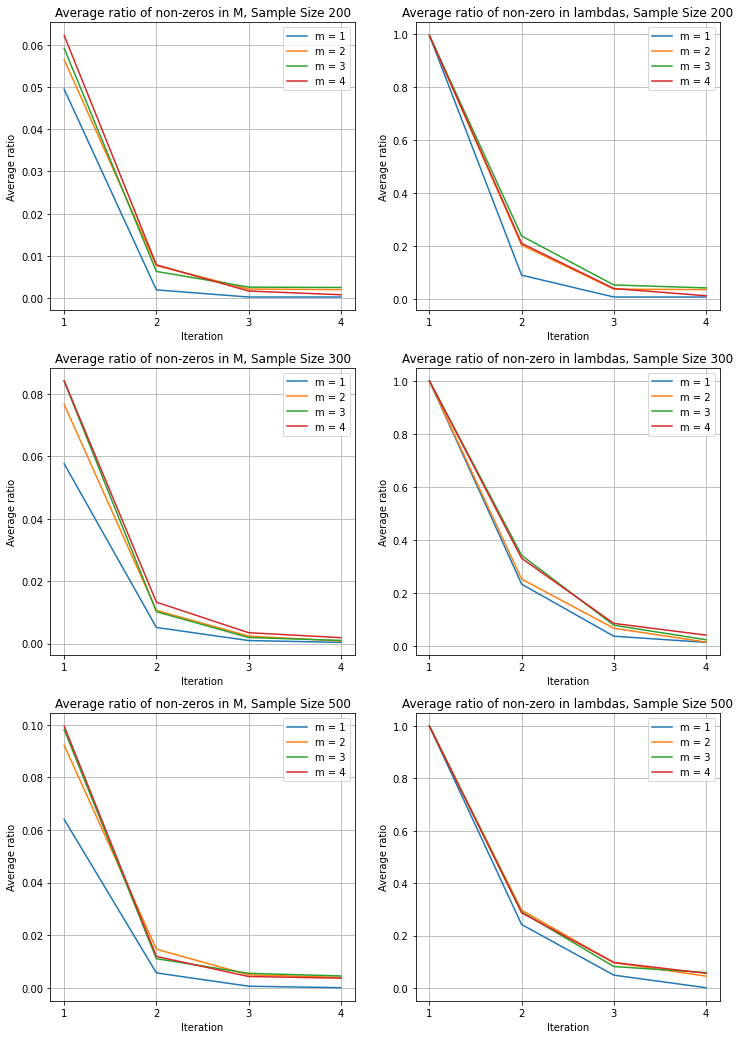

In [ ]:
fig = plt.figure(figsize=(12,18))
i = 0

for l in range(len(groups_avg_metrics)):

  nonzeroM_avg = groups_avg_metrics[l][2]
  nonzeroL_avg = groups_avg_metrics[l][3]

  i += 1
  plt.subplot(3,2,i)
  for k in range(m):
    plt.plot(np.arange(1,n_iters+1), np.array(nonzeroM_avg)[:,k], label='m = {}'.format(k+1))
  plt.xticks(np.arange(1,n_iters+1))
  plt.title('Average ratio of non-zeros in M, Sample Size {}'.format(sizes[l+1]))
  plt.ylabel('Average ratio')
  plt.xlabel('Iteration')
  plt.legend()
  plt.grid()

  i += 1
  plt.subplot(3,2,i)
  for k in range(m):
    plt.plot(np.arange(1,n_iters+1), np.array(nonzeroL_avg)[:,k], label='m = {}'.format(k+1))
  plt.xticks(np.arange(1,n_iters+1))
  plt.title('Average ratio of non-zero in lambdas, Sample Size {}'.format(sizes[l+1]))
  plt.ylabel('Average ratio')
  plt.xlabel('Iteration')
  plt.legend()
  plt.grid()
  
plt.show()

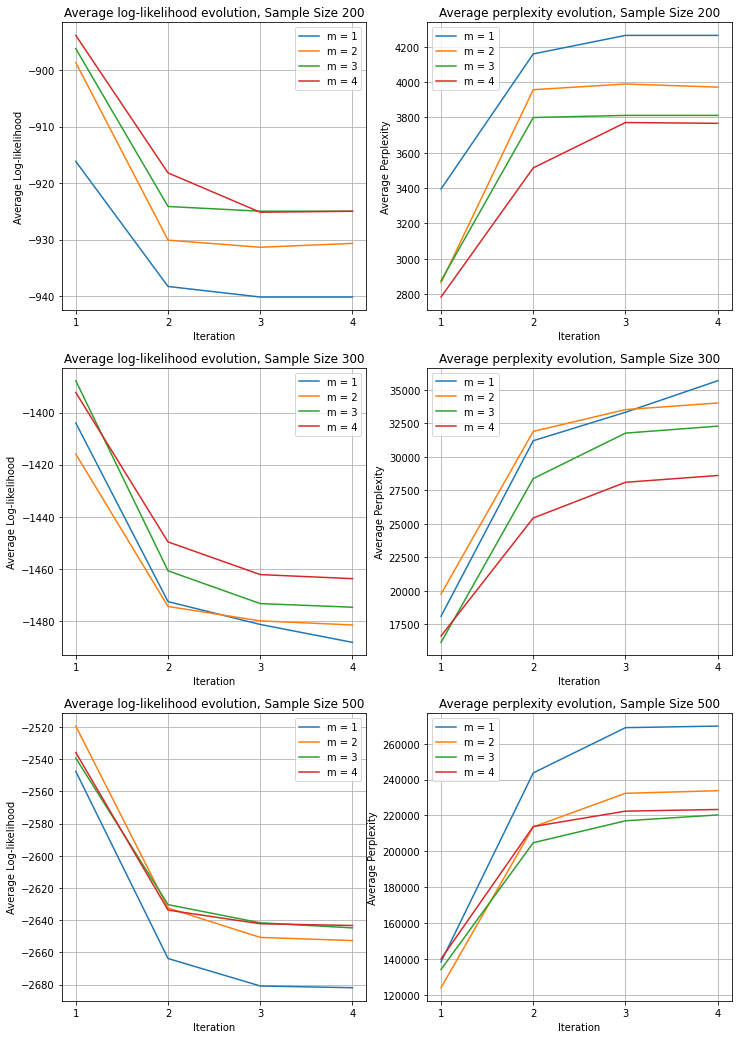

In [ ]:
fig = plt.figure(figsize=(12,18))
i = 0

for l in range(len(groups_avg_metrics)):

  logliks_avg = groups_avg_metrics[l][0]
  ppxs_avg = groups_avg_metrics[l][1]

  i += 1
  plt.subplot(3,2,i)
  for k in range(m):
    plt.plot(np.arange(1,n_iters+1), np.array(logliks_avg)[:,k], label='m = {}'.format(k+1))
  plt.xticks(np.arange(1,n_iters+1))
  plt.title('Average log-likelihood evolution, Sample Size {}'.format(sizes[l+1]))
  plt.ylabel('Average Log-likelihood')
  plt.xlabel('Iteration')
  plt.legend()
  plt.grid()

  i += 1
  plt.subplot(3,2,i)
  for k in range(m):
    plt.plot(np.arange(1,n_iters+1), np.array(ppxs_avg)[:,k], label='m = {}'.format(k+1))
  plt.xticks(np.arange(1,n_iters+1))
  plt.title('Average perplexity evolution, Sample Size {}'.format(sizes[l+1]))
  plt.ylabel('Average Perplexity')
  plt.xlabel('Iteration')
  plt.legend()
  plt.grid()
  
plt.show()

In [ ]:
# predictions

import random

def decision(probability):
    return random.random() < probability

# algorithm 2 v.2
def new_obs(t, last_m_words, uniques, m, M, lambdas):
  ix = uniques.index(last_m_words[m-1]) # index of the current word
  stop = False
  k = 0
  while (stop == False) & (k<m):
    weights = M[k,:,ix] # probabilities that any word is preceded by current word
    sum_of_weights = np.sum(weights)
    
    nonzero_els = np.count_nonzero(weights!=0)
    #print(nonzero_els)
    rest = 0
    if nonzero_els < 5: # if there are less than 5 non-zero probabilities in weights
      k_ = nonzero_els
      rest = 5 - nonzero_els
      choices = list(np.random.choice(uniques_, k_, replace=False, p=weights/sum_of_weights)) # take as many positive as there are
      for r in range(rest): 
        choices += list(np.random.choice(uniques_, 1, replace=True, p=None)) # and pad the rest with random words
    else:
      choices = list(np.random.choice(uniques_, 5, replace=False, p=weights/sum_of_weights))

    #print(choices)

    k = k+1
    if decision(lambdas[ix][k-1]): # if toss is true, stop and keep these results, otherwise predict from M[k+1]
      stop = True
      break
    ix = uniques.index(last_m_words[m-1-k])

  print('Current word: {}. Predicting from order {}'.format(uniques[ix],k-1))
  print('#{}. Pick a word.'.format(t)) # select words corresponding to those indices
  print('1. {}, 2. {}, 3. {}, 4. {}, 5. {}'.format(
      choices[0], choices[1], choices[2],
      choices[3], choices[4]))
  i = int(input()) # let the user choose
  if i == 0: return 'exit'
  else: return choices[i-1] # return new word

In [ ]:
# use samples of size 500, first iteration, choose k based on lambda values
# groups[3][2], groups_M[3][2][0], groups_L[3][2][0]

pred_length = 20
uniques_ = list(np.unique(groups[3][0]))
M_ = groups_M[3][0][0]
lambda_ = groups_L[3][0][0]
starting_seed = "harry said to ron"
new_words = []
starting_words = nltk.word_tokenize(starting_seed)
start = starting_words
exit = False
t = 1

while exit == False and t <= pred_length:
  new_word = new_obs(t, starting_words, uniques_, m, M_, lambda_)
  if new_word == 'exit':
    exit = True
    break
  new_words.append(new_word)
  starting_words += [new_word]
  starting_words = starting_words[1:]
  t = t+1

Current word: ron. Predicting from order 0
#1. Pick a word.
1. without, 2. room, 3. if, 4. behind, 5. seemed
3
Current word: if. Predicting from order 0
#2. Pick a word.
1. armchair, 2. stretching, 3. eyed, 4. voldemort, 5. flute
4
Current word: if. Predicting from order 1
#3. Pick a word.
1. hope, 2. pale, 3. skimming, 4. guilty, 5. '
1
Current word: voldemort. Predicting from order 1
#4. Pick a word.
1. hermione, 2. stop, 3. guilty, 4. ', 5. ministry
1
Current word: hermione. Predicting from order 0
#5. Pick a word.
1. so, 2. glittering, 3. might, 4. nobody, 5. plan
3
Current word: voldemort. Predicting from order 3
#6. Pick a word.
1. wait, 2. inside, 3. school, 4. parents, 5. there
1
Current word: wait. Predicting from order 0
#7. Pick a word.
1. pointing, 2. part, 3. glittering, 4. reached, 5. london
1
Current word: pointing. Predicting from order 0
#8. Pick a word.
1. yawning, 2. if, 3. will, 4. seemed, 5. office
0


In [ ]:
print(' '.join(start + new_words))

harry says to ron if if voldemort hope hermione might wait pointing
